In [121]:
import keras
import sklearn
import xgboost
import textblob
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer
import tensorflow.keras.preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
import  networkx
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
import pandas, xgboost, numpy, textblob, string
from keras.preprocessing import text, sequence
from  keras import layers, models, optimizers
from keras.wrappers.scikit_learn import KerasClassifier

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [131]:
#Read the file jdm_annotate3_120_1.txt in https://archive.ics.uci.edu/ml/datasets/Sentence+Classification having two columns.
#In the file there are two columns. They are named as text and target.
#Text column can have sentences or phrases. And target column have AIMX, OWNX, MISC, CONT, or BASE. 
#The goal is to build classifiers that would read the text and predict the target.
#Relevant paper: A. Chambers. Statistical models for text classification: Applications and analysis, Ph.D., University of California, Irvine (2013). ProQuest Dissertations and Theses.

doc1 = pd.read_csv(r"C:\\jdm_annotate3_120_1.txt", sep='\t')
text = np.asarray(doc1.text)
target = np.asarray(doc1.target)
doc = pd.DataFrame({'text':text, 'target':target})
print("The file read looks as follows:")
print(doc.head(8))

The file read looks as follows:
                                                text target
0  we test in the context of a dictator game the ...   AIMX
1  we manipulated the likelihood that individuals...   OWNX
2  our analysis reveals a positive and significan...   OWNX
3  the magnitude of the effect is of economic sig...   OWNX
4  we conclude that subtle cues might prove suffi...   OWNX
5  lured by temptation, individuals may find them...   MISC
6  self-control failure, famously termed akrasia ...   MISC
7  for example, the dieter faced with the opportu...   MISC


In [132]:
#split the dataset into training and validation 
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(doc['text'], doc['target'], train_size=.6, stratify=doc['target'])

#target column can have AIMX, OWNX, MISC, CONT, BASE. label encode the target variable
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

#create TF count vector as feature
count_vect = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
tf = count_vect.fit_transform(doc['text'])
tf_feature_names = count_vect.get_feature_names()
xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)


# create tf-idf feature vector. Word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(doc['text'])
xtrain_tfidf_word =  tfidf_vect.transform(train_x)
xvalid_tfidf_word =  tfidf_vect.transform(valid_x)

# create tf-idf feature vector. ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(doc['text'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

# create tf-idf feature vector. characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(1,1), max_features=5000)
tfidf_vect_ngram_chars.fit(doc['text'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x) 

In [133]:
# train a LDA Model

lda = LatentDirichletAllocation(n_components=5, max_iter=5, learning_method='online', learning_offset=50.).fit(tf)

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lda, tf_feature_names, 10)

Topic 0:
self conflict control citation individual strategies temptation stage individuals face
Topic 1:
citation temptation conflict self control judgment better act face urges
Topic 2:
citation self control likely decision future et relation viewed game
Topic 3:
control self behavior social pro conflict calendar participants selfish viewed
Topic 4:
individuals pro self social behavior act control decisions good citation


In [135]:
#train various ML models
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)  
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    return metrics.accuracy_score(predictions, valid_y)


# Naive Bayes on Count Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xvalid_count)
print ("NB, Count Vectors: ", accuracy)
# Naive Bayes on Word Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_word, train_y, xvalid_tfidf_word)
print ("NB, WordLevel TF-IDF: ", accuracy)
# Naive Bayes on Ngram Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("NB, N-Gram Vectors: ", accuracy)
# Naive Bayes on Character Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print ("NB, CharLevel Vectors: ", accuracy)


# Linear Classifier on Count Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_count, train_y, xvalid_count)
print ("LR, Count Vectors: ", accuracy)
# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_word, train_y, xvalid_tfidf_word)
print ("LR, WordLevel TF-IDF: ", accuracy)
# Linear Classifier on Ngram Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("LR, N-Gram Vectors: ", accuracy)
# Linear Classifier on Character Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print ("LR, CharLevel Vectors: ", accuracy)


# SVM on Ngram Level TF IDF Vectors
accuracy = train_model(svm.SVC(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("SVM, N-Gram Vectors: ", accuracy)


# Random Forest on Count Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_count, train_y, xvalid_count)
print ("RF, Count Vectors: ", accuracy)
# RF on Word Level TF IDF Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf_word, train_y, xvalid_tfidf_word)
print ("RF, WordLevel TF-IDF: ", accuracy)


# Extereme Gradient Boosting on Count Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_count.tocsc(), train_y, xvalid_count.tocsc())
print ("Xgb, Count Vectors: ", accuracy)
# Extereme Gradient Boosting on Word Level TF IDF Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf_word.tocsc(), train_y, xvalid_tfidf_word.tocsc())
print ("Xgb, WordLevel TF-IDF: ", accuracy)
# Extereme Gradient Boosting on Character Level TF IDF Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf_ngram_chars.tocsc(), train_y, xvalid_tfidf_ngram_chars.tocsc())
print ("Xgb, CharLevel Vectors: ", accuracy)


#encode the target string to integers using the scikitlearn class LabelEncoder. Then convert the vector of integers to a one hot encoding using the keras function to categorical
from sklearn.preprocessing import LabelEncoder
from keras import utils as np_utils
from keras.utils import to_categorical
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

#encode class value as integer
encoder_train = LabelEncoder()
encoder_train.fit(train_y)
encoded_train_target = encoder_train.transform(train_y)
dummy_target_train = np_utils.to_categorical(encoded_train_target)

encoder_valid = LabelEncoder()
encoder_valid.fit(valid_y)
encoded_valid_target = encoder_train.transform(valid_y)
dummy_target_valid = np_utils.to_categorical(encoded_valid_target)

encoder_allydata = LabelEncoder()
encoder_allydata.fit(doc['target'])
encoded_allydata = encoder_allydata.transform(doc['target'])
dummy_allydata = np_utils.to_categorical(encoded_allydata)

cvec = CountVectorizer(stop_words='english')
xx = cvec.fit(doc['text'])
dummyall_x = pd.DataFrame(cvec.transform(doc['text']).todense(), columns=cvec.get_feature_names())

NB, Count Vectors:  0.5625
NB, WordLevel TF-IDF:  0.75
NB, N-Gram Vectors:  0.75
NB, CharLevel Vectors:  0.75
LR, Count Vectors:  0.8125
LR, WordLevel TF-IDF:  0.75
LR, N-Gram Vectors:  0.75
LR, CharLevel Vectors:  0.75
SVM, N-Gram Vectors:  0.75
RF, Count Vectors:  0.8125
RF, WordLevel TF-IDF:  0.78125


C:\Users\admin\Anaconda3\envs\keras2\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\admin\Anaconda3\envs\keras2\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\admin\Anaconda3\envs\keras2\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\admin\Anaconda3\envs\keras2\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 

Xgb, Count Vectors:  0.75
Xgb, WordLevel TF-IDF:  0.8125
Xgb, CharLevel Vectors:  0.78125


In [136]:
#Basic neural network
          
vectorizer = CountVectorizer(binary=True, stop_words=stopwords.words('english'), lowercase=True, min_df=1, max_df=0.9, max_features=5000)
X_train_onehot = vectorizer.fit_transform(train_x)

def baseline_model():
    model = Sequential()
    model.add(Dense(units = 10, activation = 'relu', input_dim = len(vectorizer.get_feature_names())))
    model.add(Dense(units=5, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = baseline_model()
model.fit(X_train_onehot[:-5], dummy_target_train[:-5], epochs=2, batch_size=128, shuffle=True, validation_split = 0.1, verbose=1, validation_data=(X_train_onehot[-5:], dummy_target_valid[-5:]))
scores = model.evaluate(vectorizer.transform(valid_x), dummy_target_valid, verbose=1)
print("Accuracy:", scores[1])


Train on 42 samples, validate on 5 samples
Epoch 1/2
42/42 [==============================] - 2s 40ms/sample - loss: 1.5332 - acc: 0.3571 - val_loss: 1.4282 - val_acc: 0.6000
Epoch 2/2
32/32 [==============================] - 0s 407us/sample - loss: 1.5068 - acc: 0.5312
Accuracy: 0.53125


Found 706 unique tokens.
Shape of data tensor: (79, 250)
Shape of label tensor: (79, 5)
(71, 250) (71, 5)
(8, 250) (8, 5)
Train on 63 samples, validate on 8 samples
Epoch 1/2
63/63 [==============================] - 9s 142ms/sample - loss: 1.6191 - acc: 0.1111 - val_loss: 1.5885 - val_acc: 0.6250
Epoch 2/2
8/8 [==============================] - 0s 19ms/sample - loss: 1.5773 - acc: 0.5000
Test set
  Loss: 1.577
  Accuracy: 0.500


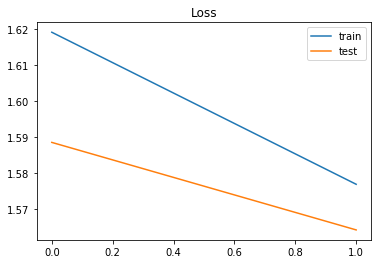

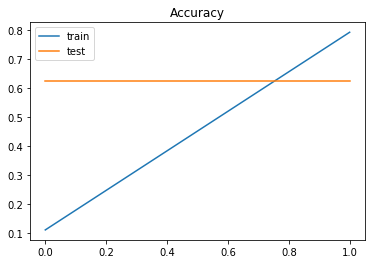

In [137]:
#LSTM and CNN. 
#Sequence data have a 1 d spatial structure. Using CNN may help to pick out invariant features for the target. 
#The learned CNN spatial features are then Learned as sequences by the LSTM later.


#MAX NO OF WORDS TO BE USED
MAX_NB_WORDS=50000
#max no of words in each complaint
MAX_SEQUENCE_LENGTH=250
EMBEDDING_DIM= 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(doc['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = tokenizer.texts_to_sequences(doc['text'].values)
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Y = pd.get_dummies(doc['target']).values
print('Shape of label tensor:', Y.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
#for CNN
model.add(tensorflow.keras.layers.SpatialDropout1D(0.2))
model.add(Conv1D(filters=100, kernel_size=10, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

#model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 2
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

In [7]:
#References:
#https://archive.ics.uci.edu/ml/datasets/Sentence+Classification
#https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17
#https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/
#https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730